In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from Functionality import Reduce_numerical_columns,Reduce_text_change,Reduce_event,Reduce_activity,getX_Y,getModel,performCrossValidation,makePredictions,perfromGridSearch,performKfoldScore,Aggregation,ConcatAlongId
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
import re
import copy
import string
import seaborn as sns
import statistics
from sklearn.model_selection import KFold,train_test_split
import lightgbm as lgb
import tqdm

/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directories Where the data is present
train_logs_directory = os.path.join("Data","train_logs.csv")
train_scores_directory = os.path.join("Data","train_scores.csv")
test_logs_directory = os.path.join("Data","test_logs.csv")

# Loading Dataset

In [3]:
# following the naming convention that everything related
# to train will be followed by train_ and everything followed by test will be followed by test_
train_logs_df = pd.read_csv(train_logs_directory)
test_logs_df = pd.read_csv(test_logs_directory)
train_scores_df = pd.read_csv(train_scores_directory)

In [4]:
train_df = pd.merge(train_logs_df,train_scores_df,on = "id",how = "inner")
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


# Exploratory Data Analysis

In [5]:
# No null values are present
# train_logs_df.isnull().sum()

In [6]:
train_df.dtypes

id                  object
event_id             int64
down_time            int64
up_time              int64
action_time          int64
activity            object
down_event          object
up_event            object
text_change         object
cursor_position      int64
word_count           int64
score              float64
dtype: object

In [7]:
train_df.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count', 'score'],
      dtype='object')

In [8]:
train_df["up_event"].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'm', 'Rightclick', 'i', 'o', 't', '=', 'a',
       'CapsLock', 'Control', 'c', 'v', '/', 'Delete', ':', 'z', '[', '$',
       '(', ')', '+', 'Home', 'End', '\\', 'Meta', '*', '&',
       'AudioVolumeMute', 'x', '!', 'Insert', 'MediaPlayPause', 'w',
       'NumLock', '%', 'V', 'b', '>', 'Alt', 'AudioVolumeUp',
       'ContextMenu', 'AudioVolumeDown', 'n', 'e', '<', 'PageDown', ']',
       'Middleclick', '@', 'F12', 'u', 'j', 's', '\x96', 'Dead', 'y', '{',
       'ScrollLock', '¿', 'p', 'Process', '}', 'MediaTrackPrevious',
       'MediaTrackNext', 'F3', '^', 'Unidentified', 'Cancel', 'h', '2',
       'd', 'r', '`', '\x9b', 'f', 'g', '#', '~', 'PageUp', 'l', 'T', 'A',
       'S', 'ModeChange', '_', 'Escape', 'F11', 'Unknownclick',
       'AltGraph', 'F10', 'F15', 'Clear', 'OS', 'C', 'Ä±', 'M', '|',
       'â\x80\x93', 

In [9]:
# Highly skewed dataset
train_df["activity"].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace',
       'Move From [284, 292] To [282, 290]',
       'Move From [287, 289] To [285, 287]',
       'Move From [460, 461] To [465, 466]', 'Paste',
       'Move From [905, 1314] To [907, 1316]',
       'Move From [565, 743] To [669, 847]',
       'Move From [669, 847] To [565, 743]',
       'Move From [1041, 1121] To [1496, 1576]',
       'Move From [1455, 1557] To [1323, 1425]',
       'Move From [2268, 2275] To [2247, 2254]',
       'Move From [213, 302] To [902, 991]',
       'Move From [0, 158] To [234, 392]',
       'Move From [460, 465] To [925, 930]',
       'Move From [810, 906] To [816, 912]',
       'Move From [186, 187] To [184, 185]',
       'Move From [140, 272] To [299, 431]',
       'Move From [114, 140] To [272, 298]',
       'Move From [1386, 1450] To [1445, 1509]',
       'Move From [442, 524] To [296, 378]',
       'Move From [408, 414] To [390, 396]',
       'Move From [1144, 1147] To [1142, 1145]',
       'Move 

In [10]:
train_df["activity"]

0          Nonproduction
1          Nonproduction
2          Nonproduction
3                  Input
4                  Input
               ...      
8405893    Nonproduction
8405894    Nonproduction
8405895          Replace
8405896    Nonproduction
8405897            Input
Name: activity, Length: 8405898, dtype: object

In [11]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [12]:
train_df["text_change"]

0          NoChange
1          NoChange
2          NoChange
3                 q
4                 q
             ...   
8405893    NoChange
8405894    NoChange
8405895      q => q
8405896    NoChange
8405897           .
Name: text_change, Length: 8405898, dtype: object

# Working on the essay part and adding more features

In [13]:
def EssayGenerator(temp_df):
    essay_text = ""
    

    for index,i in temp_df.iterrows():
    
        cursor_position = i["cursor_position"]
        # print("This is essay : " ,essay_text)
    
        if i["activity"] == "Input":
            essay_text = essay_text[:cursor_position - len(i["text_change"])] + i["text_change"] + essay_text[cursor_position - len(i["text_change"]):]
            continue
    
        if i["activity"] == "Replace":
            # cursor position is after the operation
            replace_text = i["text_change"].split(" => ") # replace_text = ["original word" , "newWord"]
            essay_text = essay_text[:cursor_position - len(replace_text[1])] + replace_text[1] + essay_text[cursor_position - len(replace_text[1]) + len(replace_text[0]):]
            continue

        if i["activity"] == "Remove/Cut":
            remove_word = i["text_change"]
            essay_text = essay_text[:cursor_position] + essay_text[cursor_position+ len(remove_word):]
            continue
    
        
        if i["activity"] == "Paste":
            text = i["text_change"]
            essay_text = essay_text[:cursor_position-len(text)] + text + essay_text[cursor_position - len(text):]
            continue
    
        if i["activity"].startswith("Move"):
            text = i["activity"]
            matches = re.findall(r'\[.*?\]', text)
            arrays = [eval(match) for match in matches]
    
            # Move the text from array[0] to array[1] postion 
            if arrays[0][0] < arrays[1][0]:
                # Here movement is done from the lower of the text to the higher part of the tex+t
                essay_text = essay_text[:arrays[0][0]] + essay_text[arrays[0][1] : arrays[1][0]] + essay_text[arrays[0][0] : arrays[0][1]] + essay_text[arrays[1][0]:]
            else:
                # Here movement is done from the higher end to the lower end 
                essay_text = essay_text[:arrays[1][0]] + essay_text[arrays[0][0]: arrays[0][1]] + essay_text[arrays[1][0]: arrays[0][0]] + essay_text[arrays[0][1]:]
            continue
    return essay_text

def count_punctuations(sentence):
    punctuation_count = sum(1 for char in sentence if char in string.punctuation)
    return punctuation_count

In [14]:
def GetEssay(train_logs_df,train_postprocessed_df):
    temp_df = copy.deepcopy(train_logs_df)
    
    grouped_df = temp_df.groupby("id")
    with tqdm.tqdm(total=len(grouped_df), desc="Generating Essays") as pbar:
        def process_group(group):
            essay_result = EssayGenerator(group)
            pbar.update(1) 
            return essay_result
    
        essay = grouped_df.apply(process_group)
    final_df = pd.DataFrame(essay).reset_index()
    final_df.columns = ["_id","essay"]
    

    final_df = pd.merge(final_df,train_postprocessed_df,on = "_id",how = "inner")
    

    #Adding essay Level features
    
    # {'+', '&', '\x99', '[', '~', '|', 'e', '\\', '\x96', '_', '.', '%', 'o', '\x86', '¡', 'g', '@', 'Ë', 
    #  'h', 'C', '$', 'n', '<', 'Ä', ']', '-', '*', 'â', '^', '`', '=', '·', '#', ',', '(', 'Å', 'a', '\xa0', '\x92', 
    #  '\x9b', '\x93', '?', 'N', '\x80', '\x97', ';', '"', ')', '\x9f', "'", '/', '\x94', 'ä', ':', '}', ' ', '!', '{', '¿', '>', '\n', 'q', '±', 'Â', '´'}
    
    final_df["number_of_commas_in_essay"] = final_df["essay"].str.count(",")
    final_df["number_of_exclamation_in_essay"] = final_df["essay"].str.count("!")
    final_df["number_of_questionmark_in_essay"] = final_df["essay"].str.count("\?")
    final_df["number_of_fullstops_in_essay"] = final_df["essay"].str.count(".")
    final_df["number_of_singlequotes_in_essay"] = final_df["essay"].str.count("'")
    final_df["number_of_doublequotes_in_essay"] = final_df["essay"].str.count('"')
    final_df["number_of_semicolon_in_essay"] = final_df["essay"].str.count(';')
    final_df["number_of_colon_in_essay"] = final_df["essay"].str.count(':')


    # return final_df

    #Adding the sentence length
    sentence_level_features = {
        "number_of_sentence":[],
        "max_length_sentence":[],
        "min_length_sentence":[],
        "max_punchuation_sentence":[],
        "max_number_of_spaces_per_sentence" : [],
        "min_number_of_spaces_per_sentence" : [],
        "average_length_sentence": [],
        "std_length_sentence" : [],
        "max_number_of_words_sentence":[],
        "min_number_of_words_sentence":[],
        "sum_length_of_sentence" : []
    }
    for row in final_df["essay"].apply(lambda x: re.split('\\.|\\?|\\!',x)):
        # Iterating through the sentences rowise
        row = [x.replace("\n","").strip() for x in row]
        sentence_level_features["number_of_sentence"].append(len(row))
        sentence_lengths = [len(s) for s in row]
        word_counts = [len(s.split(" ")) for s in row]
        sentence_level_features["max_length_sentence"].append(max(sentence_lengths))
        sentence_level_features["min_length_sentence"].append(min(sentence_lengths))
        sentence_level_features["max_number_of_spaces_per_sentence"].append(len(max(row,key = lambda s : len(s.split()))))
        sentence_level_features["min_number_of_spaces_per_sentence"].append(len(min(row,key = lambda s : len(s.split())))) 
        sentence_level_features["max_punchuation_sentence"].append(len(max(row,key = lambda s : count_punctuations(s))))
        sentence_level_features["average_length_sentence"].append(sum(sentence_lengths)/len(sentence_lengths))
        if len(sentence_lengths) >= 2:
            sentence_level_features["std_length_sentence"].append(statistics.stdev(sentence_lengths))
        else:
            sentence_level_features["std_length_sentence"].append(0)

        sentence_level_features["max_number_of_words_sentence"].append(max(word_counts))
        sentence_level_features["min_number_of_words_sentence"].append(min(word_counts))
        sentence_level_features["sum_length_of_sentence"].append(sum(len(x) for x in row))

    sentence_level_df = pd.DataFrame(sentence_level_features)
    final_df = pd.concat([final_df,sentence_level_df],axis = 1)

    # Adding word level features 
    word_level_features = {
        "max_word_length" : [],
        "min_word_length" : [],
        "average_word_length":[],
        "number_of_words" : [],
        "number_of_1_character_word" : [],
        "number_of_2_character_word" : [],
        "number_of_3_character_word" : [],
        "number_of_4_character_word" : [],
        "number_of_5_character_word" : [],
        "number_of_6_character_word" : [],
        "number_of_7_character_word" : [],
        
    }
    for row in final_df["essay"].str.split():
        if len(row) == 0:
            word_level_features["max_word_length"].append(0)
            word_level_features["min_word_length"].append(0)
            word_level_features["average_word_length"].append(0)
            word_level_features["number_of_words"].append(0)
            word_level_features["number_of_1_character_word"].append(0)
            word_level_features["number_of_2_character_word"].append(0)
            word_level_features["number_of_3_character_word"].append(0)
            word_level_features["number_of_4_character_word"].append(0)
            word_level_features["number_of_5_character_word"].append(0)
            word_level_features["number_of_6_character_word"].append(0)
            word_level_features["number_of_7_character_word"].append(0)
            continue
            
        word_level_features["max_word_length"].append(len(max(row,key = lambda s: len(s))))
        word_level_features["min_word_length"].append(len(min(row,key = lambda s: len(s))))
    
        average = sum([len(s) for s in row]) / len(row)

        number_of_character_word = [len(s) for s in row]
    
        word_level_features["average_word_length"].append(average)
        word_level_features["number_of_words"].append(len(row))
        word_level_features["number_of_1_character_word"].append(number_of_character_word.count(1))
        word_level_features["number_of_2_character_word"].append(number_of_character_word.count(2))
        word_level_features["number_of_3_character_word"].append(number_of_character_word.count(3))
        word_level_features["number_of_4_character_word"].append(number_of_character_word.count(4))
        word_level_features["number_of_5_character_word"].append(number_of_character_word.count(5))
        word_level_features["number_of_6_character_word"].append(number_of_character_word.count(6))
        word_level_features["number_of_7_character_word"].append(sum(i for i in number_of_character_word if i >= 7))
    

    word_level_df = pd.DataFrame(word_level_features)
    final_df = pd.concat([final_df,word_level_df],axis = 1)

    # Adding paragraph level features
    paragraph_level_features = {
        "number_of_paragraphs" : [],
        "max_length_paragraphs" : [],
        "min_length_paragraphs" : [],
        "max_number_of_spaces_paragraph" : [],
        "max_number_of_sentence_paragraph" : [],
        "min_number_of_sentence_paragraph" : [],
        "average_number_of_sentence_paragraph" : [],
        # "first_para_last_para_ratio" : [],
        # "first_and_last_para_to_rest_para_length_ratio" : [],
        # first para last para ration 
        # first + last para length body length(para) ration
    }
    for row in final_df["essay"].str.split("\n"):
        non_empty_lines = [line for line in row if line]
        number_of_sentences = [len(list(re.split(r'[.!?]', s))) for s in non_empty_lines]
        
        paragraph_level_features["number_of_paragraphs"].append(len(non_empty_lines))
        paragraph_level_features["max_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
        paragraph_level_features["min_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
        paragraph_level_features["max_number_of_spaces_paragraph"].append(len(max(non_empty_lines,key = lambda s: len(s.split())).split())-1)
        paragraph_level_features["max_number_of_sentence_paragraph"].append(max(number_of_sentences))
        paragraph_level_features["min_number_of_sentence_paragraph"].append(min(number_of_sentences))
        paragraph_level_features["average_number_of_sentence_paragraph"].append(sum(number_of_sentences)/len(number_of_sentences))
        


    paragraph_level_df = pd.DataFrame(paragraph_level_features)
    final_df = pd.concat([final_df,paragraph_level_df],axis = 1)
    
    return final_df

In [15]:
# final_df = GetEssay(train_logs_df,train_postprocessed_df)

In [16]:
# final_df["essay"][0]

In [17]:
# #Adding the sentence length
# k = 0
# sentence_level_features = {
#     "number_of_sentence":[],
#     "max_length_sentence":[],
#     "min_length_sentence":[],
#     "max_punchuation_sentence":[],
#     "max_number_of_spaces_per_sentence" : [],
#     "min_number_of_spaces_per_sentence" : [],
#     "average_length_sentence": [],
#     "std_length_sentence" : [],
#     "max_number_of_words_sentence":[],
#     "min_number_of_words_sentence":[],
# }

# for row in final_df["essay"].apply(lambda x: re.split('\\.|\\?|\\!',x)):
#     if k > 10:
#         break
#     else:
#         k+=1
#     # Iterating through the sentences rowise
#     row = [x.replace("\n","") for x in row]
#     print(row,end = "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
#     sentence_level_features["number_of_sentence"].append(len(row))
#     sentence_lengths = [len(s) for s in row]
#     word_counts = [len(s.split()) for s in row]
#     sentence_level_features["max_length_sentence"].append(max(sentence_lengths))
#     sentence_level_features["min_length_sentence"].append(min(sentence_lengths))
#     sentence_level_features["max_number_of_spaces_per_sentence"].append(len(max(row,key = lambda s : len(s.split()))))
#     sentence_level_features["min_number_of_spaces_per_sentence"].append(len(min(row,key = lambda s : len(s.split())))) 
#     sentence_level_features["max_punchuation_sentence"].append(len(max(row,key = lambda s : count_punctuations(s))))
#     sentence_level_features["average_length_sentence"].append(sum(sentence_lengths)/len(sentence_lengths))
#     sentence_level_features["std_length_sentence"].append(statistics.stdev(sentence_lengths))
#     sentence_level_features["max_number_of_words_sentence"].append(max(word_counts))
#     sentence_level_features["min_number_of_words_sentence"].append(min(word_counts))

In [18]:
#  # Adding word level features 
# word_level_features = {
#     "max_word_length" : [],
#     "min_word_length" : [],
#     "average_word_length":[],
#     "number_of_words" : [],
# }
# k = 0
# for row in final_df["essay"].str.split():
#     print(row,end = "\n\n\n\n\n\n\n\n\n\n\n\n\n")
#     k += 1
#     if k > 10: 
#         break
#     word_level_features["max_word_length"].append(len(max(row,key = lambda s: len(s))))
#     word_level_features["min_word_length"].append(len(min(row,key = lambda s: len(s))))

#     average = sum([len(s) for s in row]) / len(row)

#     word_level_features["average_word_length"].append(average)
#     word_level_features["number_of_words"].append(len(row))


In [19]:
#  # Adding paragraph level features
# paragraph_level_features = {
#     "number_of_paragraphs" : [],
#     "max_length_paragraphs" : [],
#     "min_length_paragraphs" : [],
#     "max_number_of_spaces_paragraph" : [],
# }
# k = 0
# for row in final_df["essay"].str.split("\n"):
#     k +=1 
#     if k > 10:
#         break
    
#     non_empty_lines = [line for line in row if line]
#     # print(non_empty_lines,end = "\n\n\n\n\n\n\n\n\n")
#     number_of_sentences = [len(list(re.split(r'[.!?]', s))) for s in non_empty_lines]
#     print(number_of_sentences)
#     paragraph_level_features["number_of_paragraphs"].append(len(non_empty_lines))
#     paragraph_level_features["max_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
#     paragraph_level_features["min_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
#     paragraph_level_features["max_number_of_spaces_paragraph"].append(len(max(non_empty_lines,key = lambda s: len(s.split())).split())-1)

# Data Filteration

In [20]:
# Splitting the dataset between the categorical and numerical values
num_attributes = ["id","event_id","down_time","up_time","action_time","cursor_position","word_count"]
cat_attributes = ["activity","down_event","up_event","text_change"]

In [21]:
processing = ColumnTransformer([
    ("RemoveId",make_pipeline(Reduce_numerical_columns()),num_attributes),
     ("ValueSum",make_pipeline(Reduce_text_change()),["text_change","id"]),
    ("RemoveMove",make_pipeline(Reduce_activity(),OneHotEncoder(sparse_output=False)),["activity"]),
    # ("ReduceUpEvents",make_pipeline(Reduce_event(name = "Up")),["up_event"]),
    ("ReduceDownEvents",make_pipeline(Reduce_event(name = "Down")),["down_event"]),   
],
    # remainder="passthrough"
)

In [22]:
train_logs_df,y = getX_Y(train_logs_df,train_scores_df,perform_harmonic_variation=False,aggregation=True)
train_processed_numpy = processing.fit_transform(train_logs_df)
test_processed_numpy = processing.transform(test_logs_df)
train_processed_df = pd.DataFrame(train_processed_numpy,columns=processing.get_feature_names_out())
test_processed_df = pd.DataFrame(test_processed_numpy,columns=processing.get_feature_names_out())

In [23]:
post_processing = make_pipeline(Aggregation())

In [ ]:
# Concating the columns 
train_postprocessed_df = ConcatAlongId(train_processed_df,train_logs_df)
test_postprocessed_df = ConcatAlongId(test_processed_df,test_logs_df)

# Aggreagating the columns for both train and test
train_postprocessed_numpy = post_processing.fit_transform(train_postprocessed_df)
train_postprocessed_df = pd.DataFrame(train_postprocessed_numpy,columns=post_processing.get_feature_names_out())
test_postprocessed_numpy = post_processing.transform(test_postprocessed_df)
test_postprocessed_df = pd.DataFrame(test_postprocessed_numpy,columns=post_processing.get_feature_names_out())

# # Adding the essay level features 
train_postprocessed_df = GetEssay(train_logs_df,train_postprocessed_df)
test_postprocessed_df = GetEssay(test_logs_df,test_postprocessed_df)

# Remvoing id and essay
train_postprocessed_df.drop(["_id","essay"],inplace = True,axis = 1)
test_postprocessed_df.drop(["_id","essay"],inplace = True,axis = 1)

#Convert each of types to float
train_postprocessed_df = train_postprocessed_df.astype(float)
test_postprocessed_df = test_postprocessed_df.astype(float)

In [25]:
train_postprocessed_df.columns

Index(['sum_action_time', 'mean_action_time', 'std_action_time',
       'min_action_time', 'max_action_time', 'sum_cursor_position',
       'mean_cursor_position', 'std_cursor_position', 'min_cursor_position',
       'max_cursor_position', 'sum_word_count', 'min_word_count',
       'max_word_count', 'sum_difference_time', 'mean_difference_time',
       'std_difference_time', 'min_difference_time', 'max_difference_time',
       'sum_text_change', 'mean_text_change', 'std_text_change',
       'min_text_change', 'max_text_change', 'sum_activity_Input',
       'sum_activity_Move', 'sum_activity_Nonproduction', 'sum_activity_Paste',
       'sum_activity_Remove/Cut', 'sum_activity_Replace',
       'sum_input_word_count', 'max_input_word_length_max',
       'min_input_word_length_min', 'sum_input_word_length_sum',
       'sum_Down_Punchuations', 'sum_Down_Characters', 'sum_Down_Numbers',
       'sum_Down_Operations', 'sum_Down_Unknows', 'max_event_id',
       'sum_Down_Events_0', 'sum_Down_Ev

In [42]:
# list(train_postprocessed_df["sum_length_of_sentence"])

In [ ]:
train_postprocessed_df["input_word_length_mean"]

In [ ]:
train_processed_df = ConcatAlongId(train_processed_df,train_logs_df)

In [ ]:
train_processed_df

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    final = []
    sum = 0
    for i in temp_df["Down_Punchuations"]:
        sum += i
        final.append(sum)
    plt.plot(temp_df["down_time"],final)
    k+=1
    if k == 100:
        break
plt.show()
    

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.scatter(temp_df["down_time"],temp_df["Down_Punchuations"])
    k+=1
    if k == 1:
        break
plt.show()

In [ ]:
# len(train_processed_df)

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.plot(temp_df["down_time"],temp_df["word_count"])
    k+=1
    if k == 100:
        break
plt.show()

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.plot(temp_df["down_time"],temp_df["cursor_position"])
    k+=1
    if k == 100:
        break
plt.show()

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.plot(temp_df["down_time"],temp_df["word_count"])
    # k+=1
    # if k == 100:
    #     break
plt.show()

In [ ]:
k = 0
temp = []
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    temp.append(temp_df["down_time"].iloc[-1] - temp_df["down_time"].iloc[0])
    # k+=1
    # if k == 100:
    #     break
# plt.show()

In [ ]:
len(temp)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(temp, bins=range(min(temp), max(temp) + 1), align='left', rwidth=0.8, color='skyblue')
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.title('Distribution of Numbers')
plt.show()

# Model Traning

In [ ]:
models_dict = {}
scores = []

best_params = {'reg_alpha': 0.007678095440286993,
               'reg_lambda': 0.34230534302168353,
               'colsample_bytree': 0.627061253588415,
               'subsample': 0.854942238828458,
               'learning_rate': 0.038697981947473245,
               'num_leaves': 22,
               'max_depth': 37,
               'min_child_samples': 18}


kf = KFold(n_splits=10, random_state=42 , shuffle=True)
for index, (train_index, test_index) in enumerate(kf.split(train_postprocessed_df)):

    X_train, X_valid = train_postprocessed_df.iloc[train_index],train_postprocessed_df.iloc[test_index]
    y_train,y_valid = y.iloc[train_index],y.iloc[test_index]

    params = {
        "objective": "regression",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 12001,
        "verbosity": -1,
        **best_params
    }
    model = lgb.LGBMRegressor(**params)
    early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              callbacks=[early_stopping_callback, verbose_callback],
              )
    
    models_dict[f'{model.__class__.__name__}_{index}'] = model

In [ ]:
def ConcateIdAfterPrediction(test_logs_df,test_postprocessed_df):
    temp_df = test_logs_df[["event_id","id"]].groupby("id").aggregate("mean")
    temp_df = temp_df.reset_index()
    final_df = pd.concat([test_postprocessed_df, temp_df["id"]], axis=1)
    return final_df

In [ ]:
test_predictions = [model.predict(test_postprocessed_df) for _,model in models_dict.items()]

In [ ]:
test_final_df = ConcateIdAfterPrediction(test_logs_df,test_postprocessed_df)
test_final_df["score"] = np.mean(test_predictions,axis = 0)
test_final_df[["id","score"]].to_csv("submission.csv",index = False)

In [ ]:
train_postprocessed_df.columns

In [43]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
import lightgbm as lgb
from sklearn import model_selection, metrics

models_dict = {}
scores = []
# Params = [n_estimators: 114, reg_alpha: 0.006309270522985468, reg_lambda: 0.005460447292939521, colsample_bytree: 0.7674436536160884, subsample: 0.8448372126058836, learning_rate: 0.04866328043176988, num_leaves: 56, min_child_samples: 75, max_depth: 215]

test_predict_list = []
best_params = {'reg_alpha': 0.0036516817752237723, 
               'reg_lambda': 0.004008959091986716, 
               'colsample_bytree': 0.7708371023796917, 
               'subsample': 0.9145740879908727, 
               'learning_rate': 0.04787594613028181, 
               'num_leaves': 11, 
               'max_depth': 164, 
               'min_child_samples': 56}

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_postprocessed_df.shape[0])
    X_test = test_postprocessed_df
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_postprocessed_df)):
        
        X_train = train_postprocessed_df.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_valid = train_postprocessed_df.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 269,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.log_evaluation(100)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback, verbose_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(y, oof_valid_preds, squared=False)
    scores.append(oof_score)

[100]	valid_0's rmse: 0.578133
[200]	valid_0's rmse: 0.572891
[100]	valid_0's rmse: 0.530601
[200]	valid_0's rmse: 0.535564
[100]	valid_0's rmse: 0.695252
[200]	valid_0's rmse: 0.692472
[100]	valid_0's rmse: 0.612925
[200]	valid_0's rmse: 0.611046
[100]	valid_0's rmse: 0.595558
[200]	valid_0's rmse: 0.597257
[100]	valid_0's rmse: 0.623958
[200]	valid_0's rmse: 0.622445
[100]	valid_0's rmse: 0.658083
[200]	valid_0's rmse: 0.644843
[100]	valid_0's rmse: 0.630824
[200]	valid_0's rmse: 0.62776
[100]	valid_0's rmse: 0.639277
[200]	valid_0's rmse: 0.6436
[100]	valid_0's rmse: 0.600016
[200]	valid_0's rmse: 0.611475
[100]	valid_0's rmse: 0.603277
[200]	valid_0's rmse: 0.613055
[100]	valid_0's rmse: 0.591291
[200]	valid_0's rmse: 0.59938
[100]	valid_0's rmse: 0.583742
[200]	valid_0's rmse: 0.58548
[100]	valid_0's rmse: 0.620984
[200]	valid_0's rmse: 0.6201
[100]	valid_0's rmse: 0.604802
[200]	valid_0's rmse: 0.600534
[100]	valid_0's rmse: 0.632715
[200]	valid_0's rmse: 0.633572
[100]	valid_0's

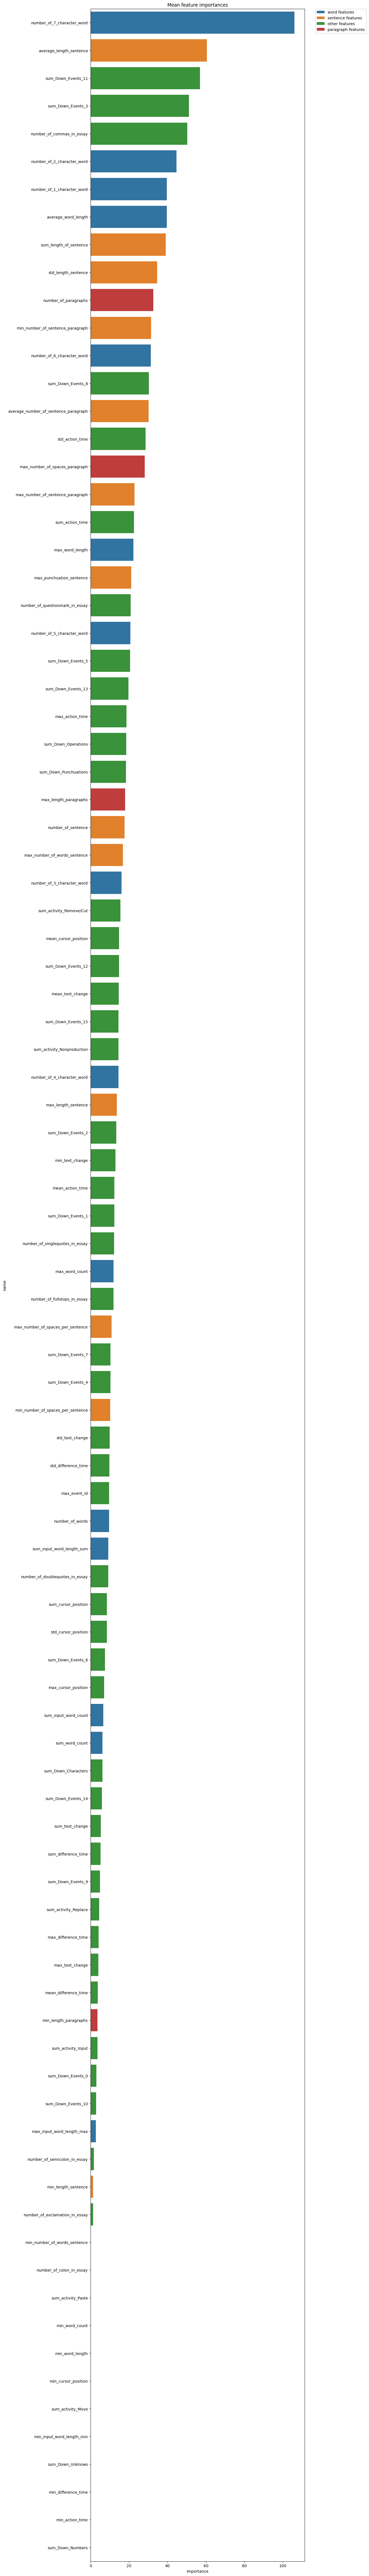

In [44]:
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': train_postprocessed_df.columns, 'importance': feature_importances_values})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df['group'] = feature_importance_df['name'].apply(
    lambda x: 'sentence features' if 'sent' in x else 'paragraph features' if 'paragraph' in x else 'word features' if 'word' in x else 'other features')

plt.figure(figsize=(10, 120))
ax = sns.barplot(data=feature_importance_df, x='importance', y='name', hue='group', dodge=False)
ax.set_title(f"Mean feature importances")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18}
params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }

lgb_model = lgb.LGBMRegressor(**params)

In [ ]:
cv_results = cross_val_score(lgb_model, train_postprocessed_df, y, cv=5, scoring='neg_mean_squared_error')


In [ ]:
cv_results

In [ ]:
#array([0.41127499, 0.36983201, 0.4229339 , 0.38716639, 0.41180781])

In [ ]:
# model = GradientBoostingRegressor(
#     n_estimators=300,
#     learning_rate=0.01,
#     max_depth=10,
#     min_samples_split=3,
#     min_samples_leaf=5,
#     subsample=0.9,
#     random_state=42
# )
model = RandomForestRegressor(
    n_estimators=3000,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

In [ ]:
results = performCrossValidation(model,train_postprocessed_df,train_logs_df,y,aggregation=True)

In [ ]:
results

In [ ]:
results

In [ ]:
model.fit(train_postprocessed_df,y)

In [ ]:
dataset_train = makePredictions(model,train_postprocessed_df,train_logs_df,aggregation=True)

In [ ]:
dataset_test = makePredictions(model,test_postprocessed_df,test_logs_df,aggregation=True) 

In [ ]:
mean_squared_error(y,dataset_train)

In [ ]:
# For submission
dataset_test["y_pred"].to_csv("submission.csv")

# Optimize with Optuna

In [ ]:
def objective(trial):
    model,params = getModel("LGBMRegressor",optuna=True,trial=trial)
    X_train, X_test, y_train, y_test = train_test_split(train_postprocessed_df, y, test_size=0.2,shuffle=True)

    # early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    # verbose_callback = lgb.log_evaluation(100)
    # model.fit(X_train,y_train,eval_set=[(X_test,y_test)],callbacks=[early_stopping_callback, verbose_callback])
    model.fit(X_train,y_train)

    preds = model.predict(X_test)

    rmse = mean_squared_error(y_test, preds,squared=False)

    return rmse
    

In [ ]:
from optuna.storages import RDBStorage
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    storage = "sqlite:///linking.db",
    study_name = "Optimize boosting hyperparameters",
)
study.optimize(objective, n_trials=200)